# Machine Learning with PyTorch

## Tasks with Networks

<font size="+1">A simple feature classifier</font>
<a href="NetworkExamples_0.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">An image classifier</font>
<a href="NetworkExamples_1.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">A regression prediction</font>
<a href="NetworkExamples_2.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1"><u><b>Clustering with PyTorch</b></u></font>
<a href="NetworkExamples_3.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Generative Adversarial Networks (GAN)</font> 
<a href="NetworkExamples_4.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Part of Speech Tagger</font>
<a href="NetworkExamples_5.ipynb"><img src="img/open-notebook.png" align="right"/></a>

In [1]:
from collections import namedtuple
import math
import numpy as np
import torch

## Clustering with PyTorch

We can implement the [K-means clustering algorithm](https://en.wikipedia.org/wiki/K-means_clustering) using PyTorch tensor arithmetic fairly easily.  Unlike other examples in this lesson, we do not utilize the `torch.nn` subpackage, and the calculation is not really a neural network.  Nonetheless, this kind of technique is common in machine learning, and is interesting to present here.

Note that the technique given here **does not** guarantee convergence to a global optimum.  Choosing different initial points could quite possibly cause convergence to different centroids.  However, this approach is computationally tractable, while the global solution is NP-hard.

### Pairwise distance

We will first write one support function to find the pairwise distances between all combinations of points in two tensors.

In [2]:
def pairwise_distance(tensor1, tensor2=None, device=None):
    """Calculate pairwise Euclidian distance between tensors
    
    The input data are N*M tensors.  If the second tensor is omitted, we measure
    self-distance of the first tensor. We calculate distance by:
    
    1. expand the N*M tensors into N*1*M and 1*N*M tensors
    2. Perform a pairwise distance calculation
    """
    # If second not given, calculate self-distance
    tensor2 = tensor2 if tensor2 is not None else tensor1
    A = tensor1.unsqueeze(dim=1)  # N x 1 x M
    B = tensor2.unsqueeze(dim=0)  # 1 x N x M

    # Our N*N tensor for pairwise distance
    distances = (A-B)**2.0
    distances = torch.sqrt(distances.sum(dim=-1).squeeze())
    return distances

Just to make sure it is clear what the PyTorch function is doing, let us break it down slightly to a scalar computation, and see what the pairwise version gives us.

In [3]:
def distance_3d(a, b):
    "For comparison, a single distance calculation"
    return math.sqrt((a.x - b.x)**2 + (a.y - b.y)**2 + (a.z - b.z)**2)

In [4]:
Point3D = namedtuple('Point3D', 'x y z')
a1, a2 = Point3D(1, 2, 3), Point3D(4, 5, 6)
b1, b2 = Point3D(11, 12, 13), Point3D(14, 15, 16)

print("A points:", a1, a2)
print("B points:", b1, b2)
print()
print("From a1:", distance_3d(a1, b1), distance_3d(a1, b2))
print("From a2:", distance_3d(a2, b1), distance_3d(a2, b2))

A points: Point3D(x=1, y=2, z=3) Point3D(x=4, y=5, z=6)
B points: Point3D(x=11, y=12, z=13) Point3D(x=14, y=15, z=16)

From a1: 17.320508075688775 22.516660498395403
From a2: 12.12435565298214 17.320508075688775


In [5]:
A = torch.Tensor([a1, a2])
B = torch.Tensor([b1, b2])
print(A)
print(B)

pairwise_distance(A, B)

tensor([[1., 2., 3.],
        [4., 5., 6.]])
tensor([[11., 12., 13.],
        [14., 15., 16.]])


tensor([[17.3205, 22.5167],
        [12.1244, 17.3205]])

In [6]:
pairwise_distance(A)

tensor([[0.0000, 5.1962],
        [5.1962, 0.0000]])

## The K-means algorithm

The general idea is that we select points closest to each candidate centroid, then repeatedly move the centroid to actually fall at the middle of the selected points.  Then on the next pass, we re-select those points that are closest to the adjusted centroid (which likely differs from those in the prior pass).  After a while this process converges, and we stop when one iteration of centroids differs very little (less than a tolerance) to the last iteration.

A thing to notice about the K-means algorithm is that it works by finding [Voroni tesselations](https://en.wikipedia.org/wiki/Voronoi_diagram) of the parametric space.  Concretely, that means that the partitioning is into convex hulls, which limits those clusters that can be recognized.  However, in high dimensional parametric space, almost all distributions are well divided in practice.

In [7]:
def initial_points(X, n):
    """Given a tensor of observations select initial points for centroids
    
    This is the Forgy algorithm that simply chooses initial points from the data.
    Other techniques include Random Partition, Maximin, and Bradley & Fayyad    
    """
    indices = np.random.choice(len(X), n)
    return X[indices]

In [8]:
def kmeans(X, n_clusters, tol=1e-5):
    """The K-means clustering algorithm, speficially Lloyd's algorithm
    
    Return both the clusters and the centroids
    """
    centroids = initial_points(X, n_clusters)
    
    # Avoid repeatedly squaring the tensor elements
    sqrt_tol = math.sqrt(tol)
    
    # Repeatedly adjust centroids until less than `tol` between each move
    while True:
        # Compute the distances from points to centroids
        distances = pairwise_distance(X, centroids)
        # Which centroid of this iteration is each point closest to?
        clusters = torch.argmin(distances, dim=1)
        # Ready for the next generation
        centroids_pre = centroids.clone()

        # Move each of the centrods
        for ndx in range(n_clusters):
            selected = torch.nonzero(clusters==ndx).squeeze()
            selected = torch.index_select(X, 0, selected)
            centroids[ndx] = selected.mean(dim=0)

        # Measure the shift since last iteration, if small break
        shift = torch.sum(torch.sqrt(torch.sum((centroids-centroids_pre)**2, dim=1)))
        if shift < sqrt_tol:
            break

    # Return both the clusters and the centroids
    return clusters, centroids

## Examining clusters

Some simple clusters are presented in the overview of machine learning.  Let us use those to look at this clustering.  First we look at all the raw points.

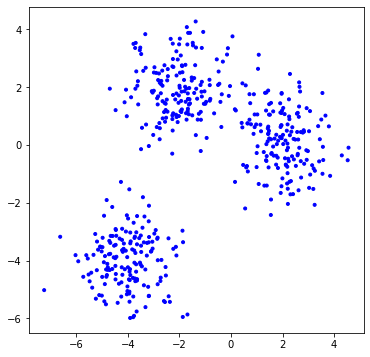

In [9]:
%matplotlib inline
from src.over_under_fit import cluster, blobs, show_clusters
cluster(1, blobs=blobs)

Next let us see the "ground truth" of the generators of the clusters.  Obviously, in real observations the point is precisely that we do not have access to that ground truth and are trying to reconstruct it.

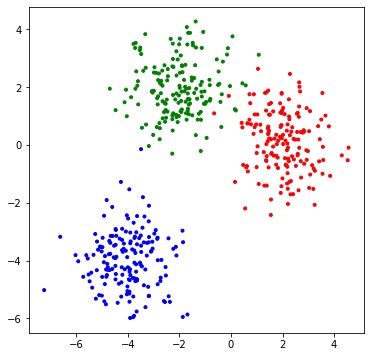

In [10]:
cluster(1, known=True, blobs=blobs)

For comparison, let us see how the K-means implemented in scikit-learn divides the clusters. Notice that it is *mostly* but not *exactly* the same as the ground truth.

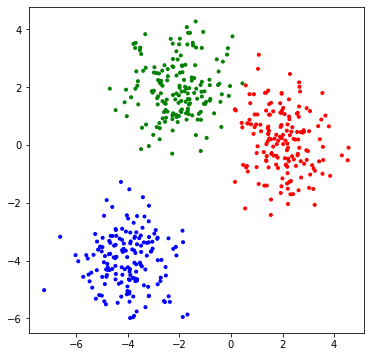

In [11]:
# Cluster using scikit-learn k-means implemenation
cluster(3, blobs=blobs)

Finally our PyTorch implementation.  For this we add the actual centroids selected as larger black circles.  Notice also that the selection of clusters is not quite identical to either the ground truth or the scikit-learn implementation.  Multiple runs of the next cell, in fact, may select slightly different clusters because the initial selection of centroids is randomized.  However, the behavior is very close in all cases, and the points that are ambiguous are also ambiguous to the human eye and judgement.

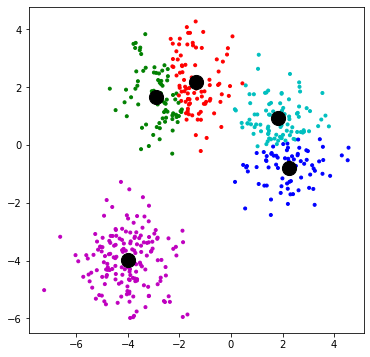

In [16]:
clusters, centroids = kmeans(torch.from_numpy(blobs), 5)
show_clusters(blobs, clusters, centroids)

## Next Lesson

**Tasks with Networks**: This lesson constructed a clustering algorithm, KMeans, using the basic tensor math in PyTorch.  The next lesson will look at Generative Adversarial Networks.

<a href="NetworkExamples_4.ipynb"><img src="img/open-notebook.png" align="left"/></a>